## 📢 MBTI Kişilik Tipi ve Dil Örüntüsü Analizi


Bu çalışmada amaç, Myers-Briggs Kişilik Tipi Göstergesi (MBTI) çerçevesinde farklı kişilik tiplerine sahip bireylerin dil kullanım örüntülerini analiz etmektir. Bunun için bir MBTI veri seti kullanılmış, veriler temizlenmiş ve daha sonra metin madenciliğine uygun hale getirilmiştir. Nihai hedef, MBTI kişilik tipleriyle yazı dili arasındaki ilişkileri keşfetmek ve örüntüler ortaya çıkarmak.

##  ❓ MBTI Nedir?

Myers–Briggs Tip Göstergesi (MBTI), bireylerin düşünme ve algılama biçimlerine göre 16 farklı kişilik tipine ayrılmasını sağlayan yaygın bir psikolojik sınıflandırma sistemidir. Bu sistem, insanların dünyayı nasıl algıladığı ve kararları nasıl aldığına dair dört temel karşıtlık üzerinden çalışır:



```
İçedönüklük (I) - Dışadönüklük (E)

Sezgi (N) - Algılama (S)

Düşünme (T) - Hissetme (F)

Yargılama (J) - Algılama (P)
```

Her birey bu dört eksende bir tercih göstererek 16 olası kişilik tipinden birine yerleşir (örn. INFP, ESTJ, vb.).

Bu çalışmada kullanılan veri seti, bireylerin çevrimiçi platformlarda (örneğin forumlar, sosyal medya) yaptığı paylaşımlar ile onların MBTI kişilik tipleri arasındaki ilişkiyi içerir.

## &nbsp;
***
## &nbsp;


## 📖  Kütüphaneler

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## &nbsp;
***
## &nbsp;


## 📌 Veri Setinin Yüklenmesi

Bu [veri kümesi](https://www.kaggle.com/datasets/datasnaek/mbti-type/data), her biri bir kişiye ait olmak üzere 8600’den fazla satır içerir.
Her satırın 2 sütunu vardır:

  - Kişinin MBTI kişilik tipi (Örn: INTJ)

  - Kişinin yaptığı son 50 paylaşım yer alır.
   - Bu paylaşımlar, metin içinde "|||" (üç dikey çizgi) ile ayrılmıştır.


Bu veriler [PersonalityCafe](https://www.personalitycafe.com/) forumu aracılığıyla toplanmıştır, çünkü burada çok sayıda insan ve MBTI kişilik tiplerinin yanı sıra yazdıkları da yer almaktadır.


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/mbti_personality_dataset.csv")

In [ ]:
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## &nbsp;
***
## &nbsp;


## 📌 Veri Setinin Tanıtımı

**✅ Veri Seti Hakkında Bilgiler**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


- Veri kümesinde yalnızca 2 sütun vardır
- Toplam satır sayısı 8675
- Veri kümesinde boş değer bulunmamaktadır
- Veriler, obje tipindedir.


In [ ]:
df.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'It has been too long since I have been on per...
freq,1832,1


- Veri setinde 16 benzersiz kişilik tipi göstergesi bulunmaktadır
- INFP, veri setimizde en sık rastlanan kişilik tipidir (görülme sayısı 1832)
- Veri kümesinde tekrar eden gönderi bulunmamaktadır

**✅ Type Sütunu Ögeleri**

In [ ]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

**✅ Her kişilik tipi için gönderi sayısı veri görselleştirmesi**

Text(0.5, 1.0, 'Total posts for each personality type')

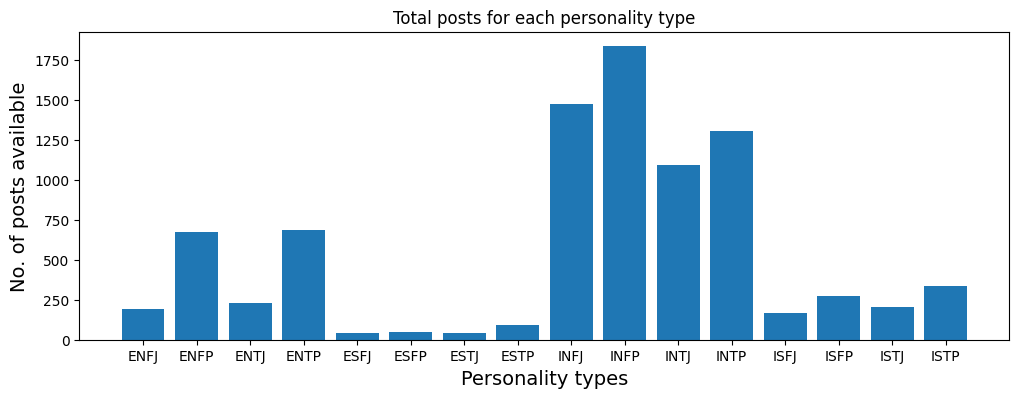

In [ ]:
total = df.groupby(['type']).count()

plt.figure(figsize = (12,4))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

⚠️ **Not:** MBTI tiplerinin dağılımı dengesizdir.
Bu nedenle bazı analizlerde bu tipler göz ardı edilebilir ya da sınıflar birleştirilebilir.

## &nbsp;
***
## &nbsp;


## 📌 Veri Ön İşleme Süreci

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 6.3 MB/s eta 0:00:00


**✅ Contractions Genişletme**

İngilizcedeki "don't", "I've", "they've" gibi yapıları genişletirek, "do not" gibi hale getirir. Bu kullanılmadığı zaman ki aksi durumda, metin temizleme işleminde "don t" gibi ifadeler oluşabilir. Bu işlem, TF-IDF gibi tekniklerde veri kalitesini artırır.


In [ ]:
import contractions

# Örnek genişletme
contractions.fix("don't")  # "do not"
contractions.fix("we've")  # "we have"

'we have'

**✅ Metin Temizleme İşlemleri**

Veriler genişletildikten sonra her gönderi üzerinde çeşitli temizlik işlemleri yapılmıştır. Bu adımda temel amaç, analizde gürültü yaratabilecek gereksiz ögeleri metinden çıkarmaktır. Uygulanan işlemler:

- Küçük harfe çevirme
- URL'lerin silinmesi
- Harf ve rakam dışındaki tüm karakterlerin temizlenmesi
- Fazla boşlukların azaltılması
- Boş kalan gönderilerin tamamen silinmesi

In [ ]:
import re
from tqdm import tqdm

# Boş değerleri at
df = df.dropna(subset=["posts"])

# MBTI kişilik tiplerini temizleyecek liste
mbti_types = [
    'infp', 'infj', 'intp', 'intj',
    'entp', 'enfp', 'istp', 'isfp',
    'entj', 'istj', 'enfj', 'isfj',
    'estp', 'esfp', 'esfj', 'estj'
]
mbti_pattern = r'\b(' + '|'.join(mbti_types) + r')\b'

def clean_text(text):
    text = str(text).lower()
    text = contractions.fix(text)  # Kısaltmaları genişlet
    text = re.sub(r'https?://[^\s<>"\']+|www\.[^\s<>"\']+', ' ', text)  # URL'leri sil
    text = re.sub(mbti_pattern, '', text)  # MBTI tiplerini sil
    text = re.sub(r'\d+', ' ', text)  # Sayıları sil
    text = re.sub(r'[^a-z\s]', ' ', text)  # Sadece harf ve boşluk bırak
    text = re.sub(r'\s+', ' ', text)  # Fazla boşlukları sadeleştir
    return text.strip()



tqdm.pandas()

#Temizleme işlemi
df['posts'] = df['posts'].progress_apply(clean_text)

#İşlem sonrası boş kalanları temizleme
df = df[df['posts'].str.strip().astype(bool)]

100%|██████████| 8675/8675 [00:39<00:00, 220.92it/s]


In [ ]:
df.head()

,type,posts
0,INFJ,and moments sportscenter not top ten plays pra...
1,ENTP,i am finding the lack of me in these posts ver...
2,INTP,good one course to which i say i know that is ...
3,INTJ,dear i enjoyed our conversation the other day ...
4,ENTJ,you are fired that is another silly misconcept...


## &nbsp;
***
## &nbsp;


## 🔧 Temel Frekans Analizi

Her kişilik tipi için:

- En sık geçen kelimeleri listelenir.
- Kelime bulutları çıkarılır. (WordCloud)
- Hangi kelimeler hangi tipte baskın → görselleştirilir

In [ ]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Temizlenmiş veriyi kopyala
df_top_words = df.copy()

# MBTI tiplerine göre analiz
mbti_types = df_top_words['type'].unique()

for mbti in mbti_types:
    subset = df_top_words[df_top_words['type'] == mbti]
    all_text = ' '.join(subset['posts'])
    words = [w for w in all_text.split() if w not in stop_words and len(w) > 2]

    word_freq = Counter(words).most_common(20)

    if word_freq:
        # Barplot
        words_, counts = zip(*word_freq)
        plt.figure(figsize=(10, 4))
        plt.bar(words_, counts)
        plt.title(f"Top 20 Words for {mbti.upper()}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        # WordCloud
        wc = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"WordCloud for {mbti.upper()}")
        plt.show()


Output hidden; open in https://colab.research.google.com to view.

## &nbsp;
***
## &nbsp;


## 🔍 TF-IDF Nedir

TF-IDF (Term Frequency–Inverse Document Frequency), metin madenciliğinde bir kelimenin bir belge içindeki önemini sayısal olarak ölçmek için kullanılır. Şu amaçla geliştirilmiştir:

  Aynı kelime hem sık geçiyorsa (TF: Term Frequency) hem de nadir belgelerde bulunuyorsa (IDF: Inverse Document Frequency) o kelime muhtemelen "özgün" ve "ayrıştırıcı" bir anlam taşıyordur.

🧠 Nasıl Çalışıyor?

    Her post için:

        Tokenizer ile metin parçalanır.

        Lemmatize edilmiş, stopword'den arındırılmış temiz bir kelime listesi elde edilir.

    TF hesaplanır: Belgedeki kelime frekansları çıkarılır.

    IDF hesaplanır: Tüm belgelerde hangi kelimenin ne kadar yaygın olduğuna bakılır.

    TF × IDF ile skorlanır: Sonuç bir sparse matris (TF-IDF Matrix) olur.
    Her satır bir kişi, her sütun bir kelime; değerler de ağırlık.

 Örnek Belgeler:
 ```
docs = [
    "I love cats and dogs",  
    "Dogs are great pets",  
    "Cats are quiet and independent"
]
```

🔹 Ne olur?

    Tokenizer + Temizleme
    → "I love cats and dogs" → ['love', 'cat', 'dog']

    TF (kelime belge içinde kaç kez geçiyor)
    → cat:1, dog:1, love:1

    IDF (kelime kaç belgede geçiyor)
    → cat: 2 belgede → idf düşer,
    → love: 1 belgede → idf yüksek

    TF-IDF skoru
    → TF × IDF yapılır, örneğin:
    "love" kelimesi az belgede geçtiği için daha "ayırıcı" olur → skoru yüksek çıkar.



> Her belge için bu şekilde kelimeler skorlara dönüşür → sonuç: bir TF-IDF matrisi oluşur.



|             | and  | are  | cats | dogs | great | independent | love | pets | quiet |
| ----------- | ---- | ---- | ---- | ---- | ----- | ----------- | ---- | ---- | ----- |
| **Belge 1** | 0.49 | 0.00 | 0.49 | 0.49 | 0.00  | 0.00        | 0.67 | 0.00 | 0.00  |
| **Belge 2** | 0.00 | 0.45 | 0.00 | 0.45 | 0.63  | 0.00        | 0.00 | 0.45 | 0.00  |
| **Belge 3** | 0.00 | 0.44 | 0.44 | 0.00 | 0.00  | 0.55        | 0.00 | 0.00 | 0.55  |


## 🔍 TF-IDF

Kelimeye böl (tokenizer)

Bazı kelimeleri temizle (stopword)

Kelimeleri köklerine indir (lemmatizer)

In [ ]:
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Gerekli NLTK verilerini indir
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# DataFrame kopyası ve NaN temizliği
df_tfidf = df.copy()
df_tfidf['posts'] = df_tfidf['posts'].fillna('')

# Stopword listelerini yükle
with open("/content/drive/MyDrive/stop_words_english.json", "r") as f:
    base_stopwords = json.load(f)

# Ekstra stopword’ler
additional_stopwords = [
    'lot', 'time', 'love', 'actually', 'seem', 'need', 'pretty', 'sure',
    'thought', 'type', 'one', 'even', 'someone', 'thing', 'make', 'now',
    'see', 'things', 'feel', 'think', 'i', 'people', 'know', 'much',
    'something', 'will', 'find', 'go', 'going', 'still', 'though', 'always',
    'through', 'really', 'want', 'way', 'never', 'say', 'it', 'many',
    'first', 'why', 'right', 'well', 'yes', 'got', 'take', 'life', 'might',
    'me', 'around', 'best', 'try', 'maybe', 'usually', 'sometimes',
    'trying', 'read', 'us', 'may', 'use', 'work', 'said', 'two', 'makes',
    'little', 'quite', 'made', 'seems', 'look', 'come', 'kind', 'long',
    'understand', 'youtube', 'tumblr', 'wp', 'jpg', 'https', 'watch',
    'video', 'link', 'test', 'tests', 'result', 'results', 'quiz', 'thread',
    'post', 'topic', 'comment', 'reply', 'good', 'nice', 'cool', 'fun',
    'happy', 'interesting', 'agree', 'point', 'question', 'guess', 'hard',
    'bad', 'great', 'infj', 'intp', 'intj', 'entp', 'enfp', 'istp', 'isfp',
    'entj', 'istj', 'enfj', 'isfj', 'estp', 'esfp', 'esfj', 'estj',
    'infps', 'intps', 'enfjs', 'intjs', 'esfjs', 'infjs', 'entjs', 'types',
    'mbti', 'entps', 'enfps', 'istps', 'isfjs', 'isfps', 'estjs', 'estps',
    'si', 'se', 'ni', 'ne', 'ti', 'te', 'fi', 'fe', 'guys', 'guy',
    'friends', 'friend', 'lol', 'haha', 'xd', 'lmao', 'omg', 'rofl',
    'okay', 'ok', 'hmm', 'huh', 'uh', 'ah', 'um', 'yeah', 'ye', 'bit',
    'don', 'doesn', 'didn', 'isn', 'wasn', 'weren', 'hasn', 'ain', 'won',
    'can', 'day', 'days', 'years', 'year', 'school', 'forum', 'problem',
    'stuff', 'start', 'high', 'big', 'close', 'talking', 'talk', 'times',
    'care', 'tend', 'wrong', 'true', 'real', 'idea', 'sound', 'function',
    'mind', 'wa', 'doe', 'lot'
]

# Stopword seti oluştur
combined_stopwords = set(base_stopwords + additional_stopwords)

# Lemmatizer
lemmatizer = WordNetLemmatizer()

# Özel tokenizer fonksiyonu


def custom_tokenizer(text):
    tokens = word_tokenize(text)
    return [
        lemmatizer.lemmatize(token.lower())
        for token in tokens
        if token.isalpha() and len(token) > 2 and token.lower() not in combined_stopwords
    ]


# TF-IDF vektörleştirme


vectorizer = TfidfVectorizer(
    tokenizer=custom_tokenizer,
    max_features=5000,
    ngram_range=(1, 1),
)



# Vektörleştir
tfidf_matrix = vectorizer.fit_transform(df_tfidf['posts'])
feature_names = vectorizer.get_feature_names_out()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**📌 Tip Bazlı İnceleme**

<ipython-input-38-6946ca7ef609>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, x='TF-IDF Difference', y='Word', palette='viridis')


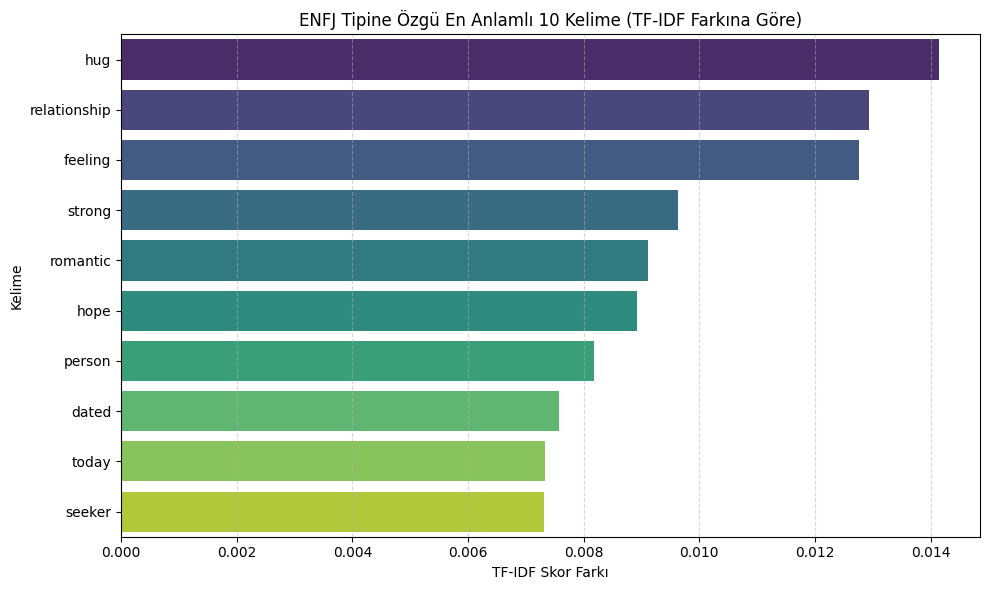

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# MBTI tipi seç
selected_type = 'ENFJ'  # Değiştirebilirsin

# Hedef tipin ortalama vektörü
target_vec = type_tfidf_df.loc[selected_type]

# Diğerlerinin ortalaması
others_vec = type_tfidf_df.drop(index=selected_type).mean()

# Fark (özgünlük farkı)
uniqueness = target_vec - others_vec

# En özgün 10 kelime ve skorları
top_unique_words = uniqueness.sort_values(ascending=False).head(10)

# DataFrame'e dök
plot_df = top_unique_words.reset_index()
plot_df.columns = ['Word', 'TF-IDF Difference']

# Bar plot çiz
plt.figure(figsize=(10, 6))
sns.barplot(data=plot_df, x='TF-IDF Difference', y='Word', palette='viridis')
plt.title(f"{selected_type} Tipine Özgü En Anlamlı 10 Kelime (TF-IDF Farkına Göre)")
plt.xlabel("TF-IDF Skor Farkı")
plt.ylabel("Kelime")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


**📌 Isı haritası**

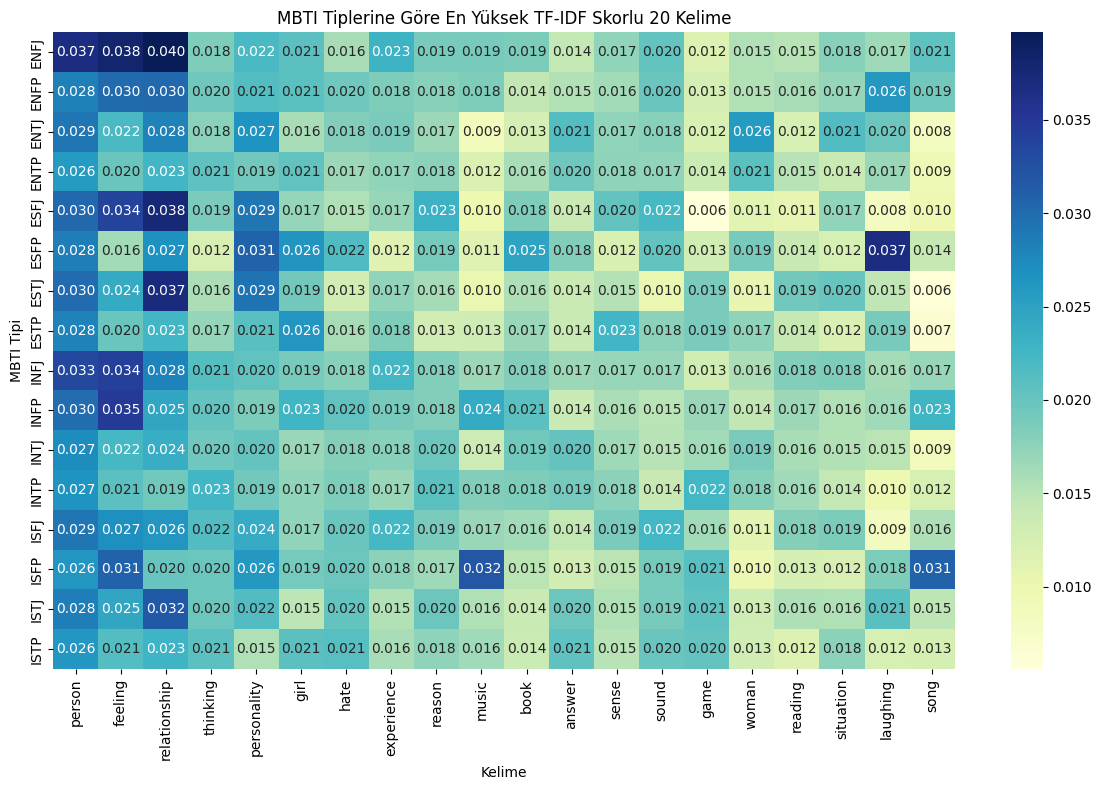

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# En baskın kelimeleri belirle (tüm veri için ortalama skora göre)
top20_words = tfidf_df.sort_values(by='mean_tfidf', ascending=False).head(20)['word'].tolist()

# Isı haritası çiz
plt.figure(figsize=(12, 8))
sns.heatmap(type_tfidf_df[top20_words], annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("MBTI Tiplerine Göre En Yüksek TF-IDF Skorlu 20 Kelime")
plt.xlabel("Kelime")
plt.ylabel("MBTI Tipi")
plt.tight_layout()
plt.show()


## &nbsp;
***
## &nbsp;


## 🛠️ N-gram

Amacımız ne?

    Sık geçen kelime çiftlerini (bigram) ya da üçlülerini (trigram) bulmak.

    Bunları MBTI türlerine göre karşılaştırmak ya da genel bir eğilim yakalamak.

    Sonuçları grafikle (bar plot veya word cloud) sunumda göstermek.

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


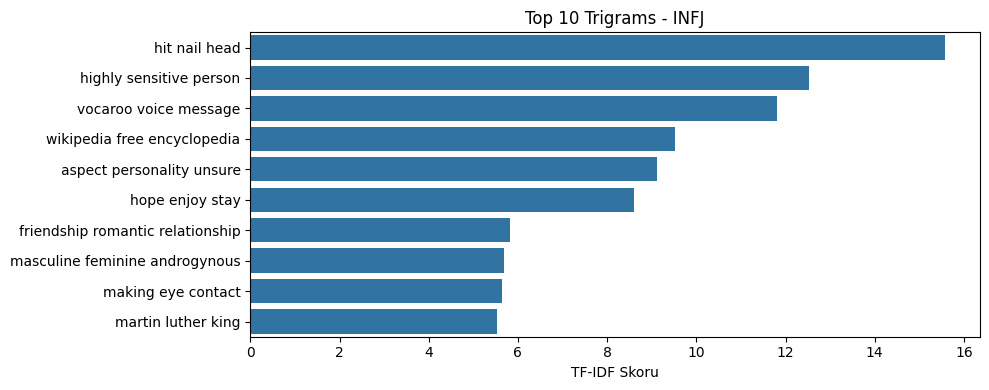

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


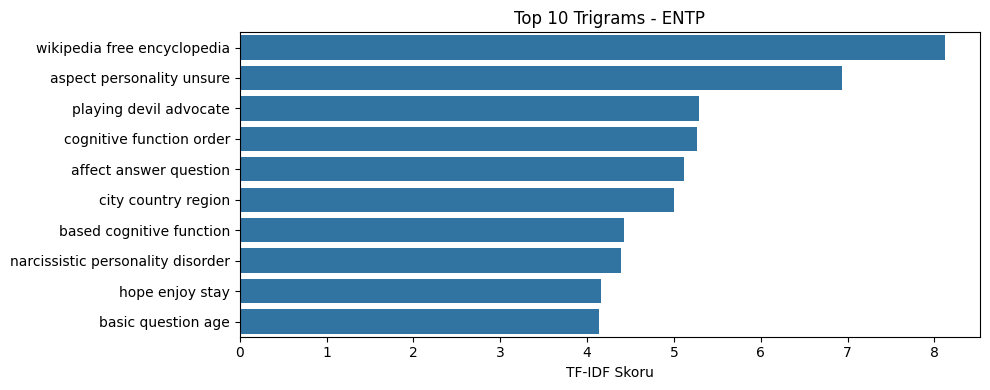

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


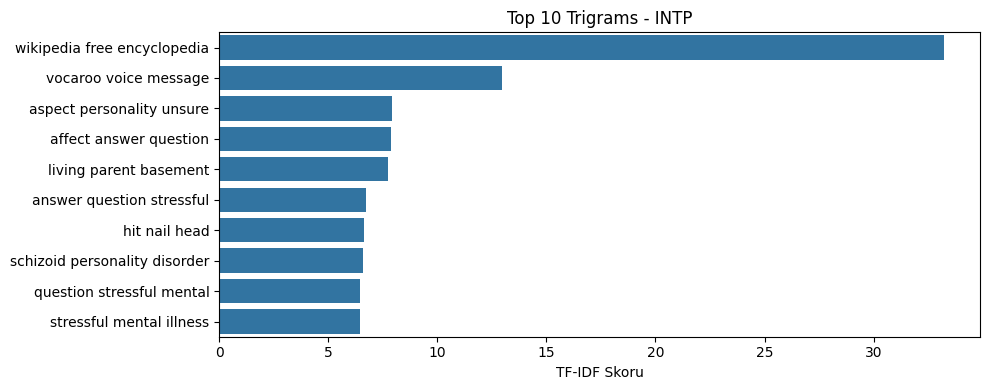

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


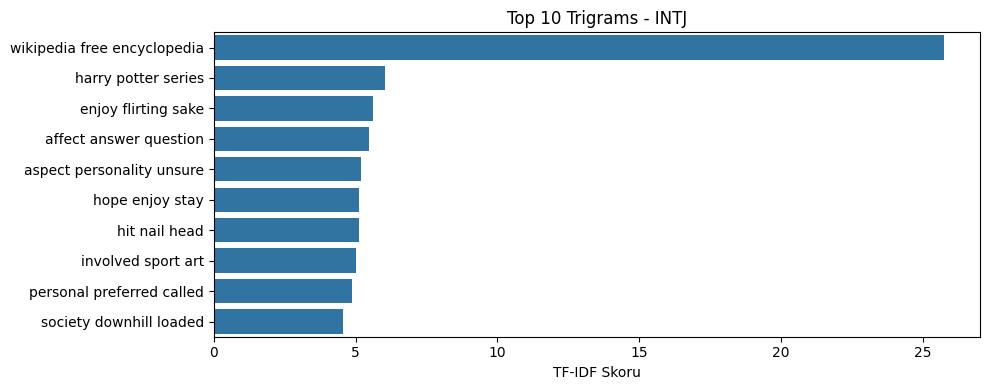

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


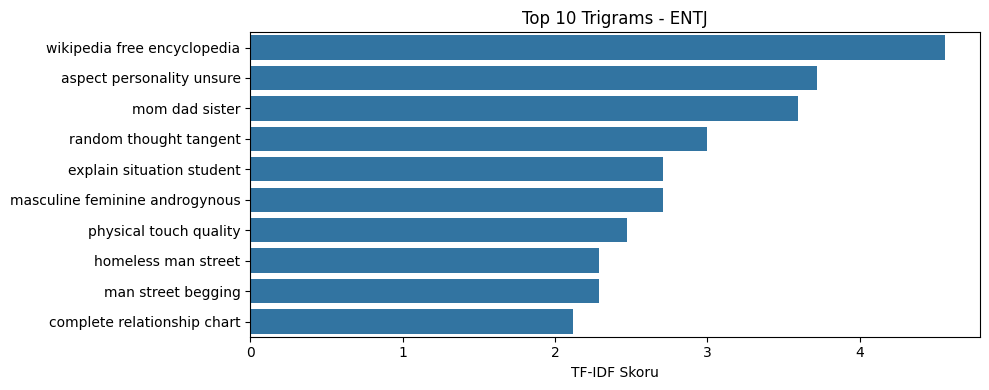

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


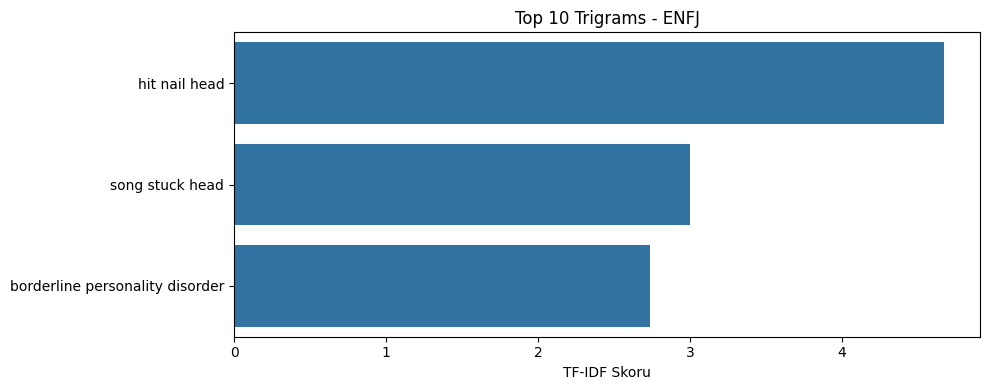

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


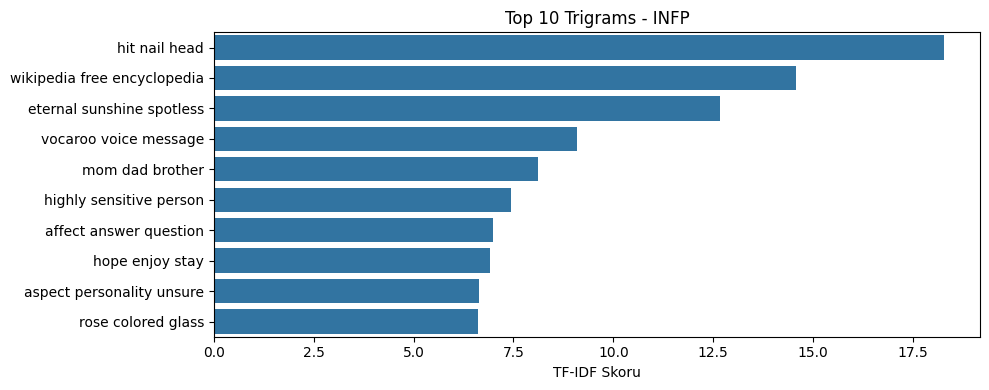

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


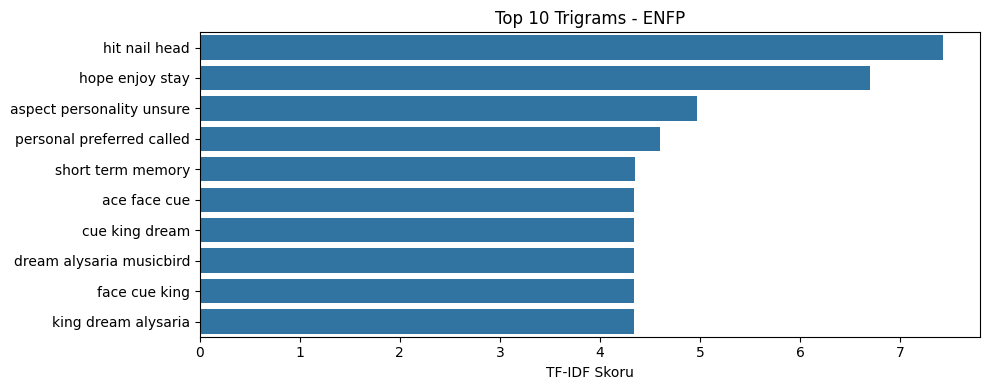

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


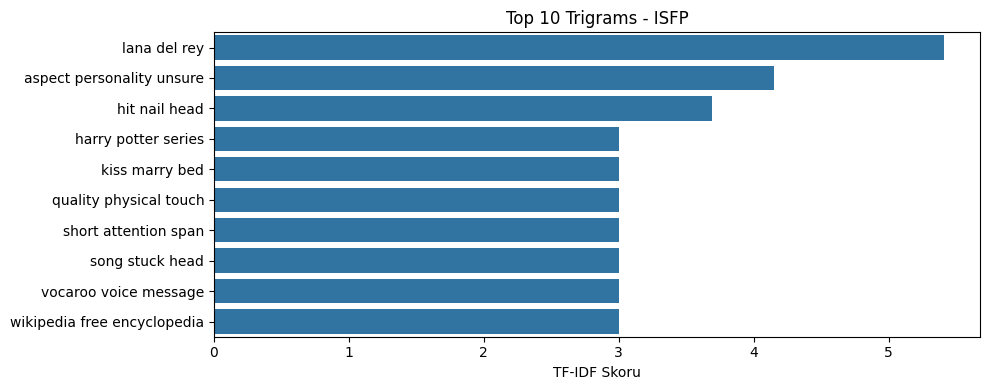

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


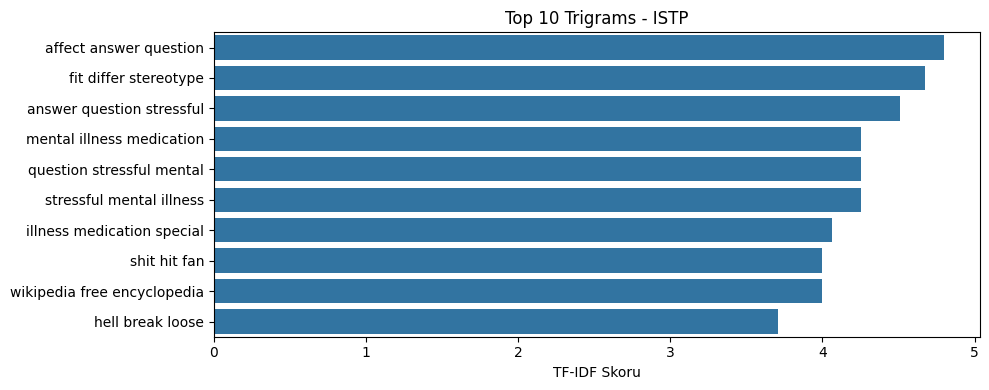

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


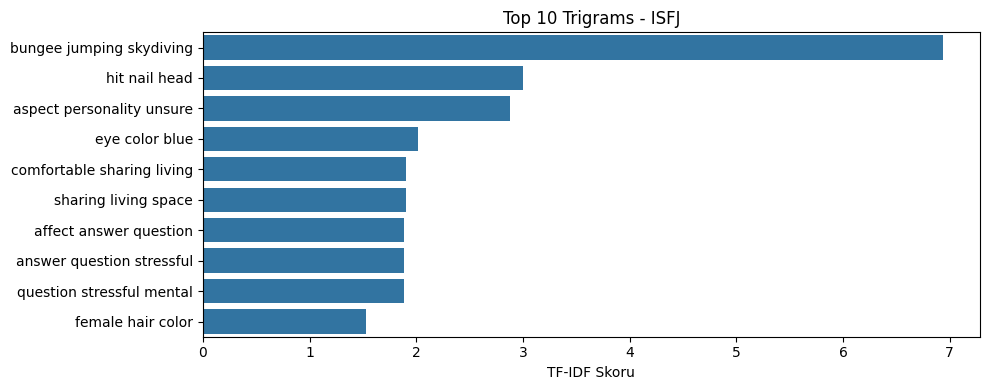

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


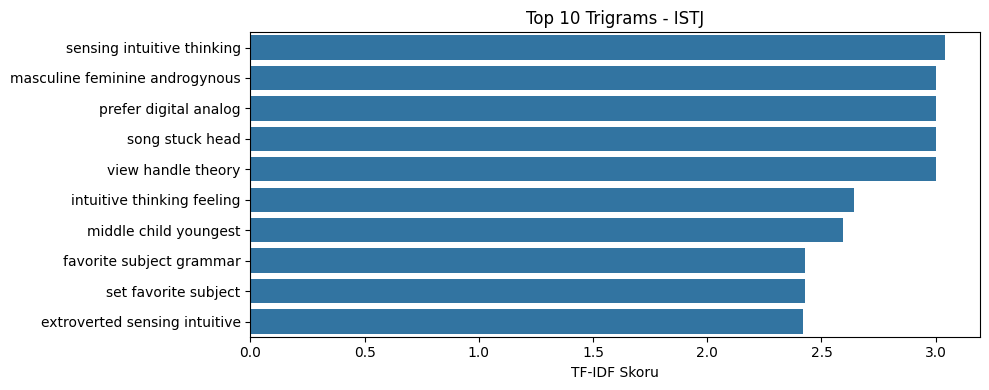

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


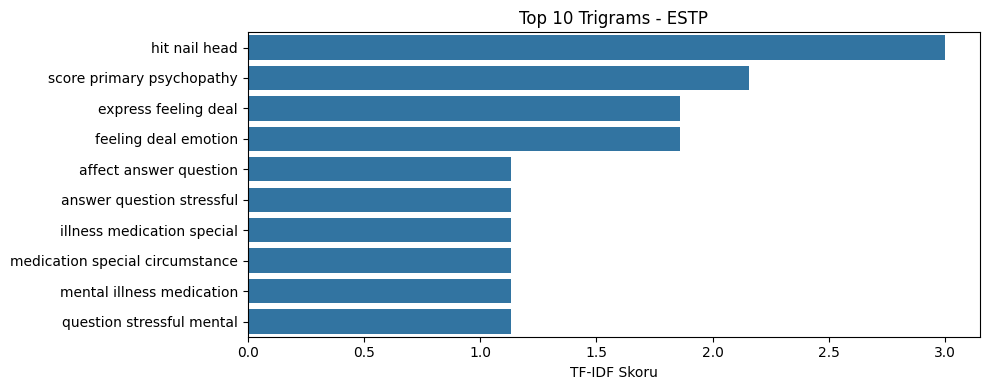

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def has_duplicate_tokens(ngram):
    tokens = ngram.split()
    return len(set(tokens)) != len(tokens)

mbti_types = df_tfidf['type'].unique()

for mbti in mbti_types:
    subset = df_tfidf[df_tfidf['type'] == mbti]

    trigram_vectorizer = TfidfVectorizer(
        tokenizer=custom_tokenizer,
        ngram_range=(3, 3),
        max_features=1000,
        min_df=3  # En az 3 kişide geçmeli
    )

    trigram_matrix = trigram_vectorizer.fit_transform(subset['posts'])
    trigram_features = trigram_vectorizer.get_feature_names_out()
    trigram_scores = trigram_matrix.sum(axis=0).A1

    # Temizle: tekrar eden trigramları çıkar
    trigram_freq = {
        trigram: score
        for trigram, score in zip(trigram_features, trigram_scores)
        if not has_duplicate_tokens(trigram)
    }

    top_trigrams = Counter(trigram_freq).most_common(10)

    if not top_trigrams:
        continue

    # Görselleştir
    terms, scores = zip(*top_trigrams)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(scores), y=list(terms))
    plt.title(f"Top 10 Trigrams - {mbti}")
    plt.xlabel("TF-IDF Skoru")
    plt.tight_layout()
    plt.show()


## &nbsp;
***
## &nbsp;
